In [43]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader   #包装可迭代的数据
import torch.utils.data as Data 

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

In [44]:
label=np.genfromtxt('image_data_label_1_1.csv',delimiter=',')
label=label.reshape((7077,1))   #设置格式
print(label.shape)
label=torch.from_numpy(label)   #将numpy转为tensor
label=label.to(torch.float32)

(7077, 1)


In [45]:
interaction_image=np.genfromtxt('image_data_1_1.csv',delimiter=',')
interaction_image=interaction_image.reshape((7077,1,32,32))
print(interaction_image.shape)
interaction_image=torch.from_numpy(interaction_image)
interaction_image=interaction_image.to(torch.float32)
print(type(interaction_image))

(7077, 1, 32, 32)
<class 'torch.Tensor'>


In [46]:
#将图像和标签拼接为一个数据集，以便进行批处理
datasets=Data.TensorDataset(interaction_image,label)

In [47]:
#划分训练集测试集   这里暂时使用8:2的划分，后续进行修改
train_size=round(1*interaction_image.shape[0])
test_size=interaction_image.shape[0]-train_size
#test_size=round(0.1*interaction_image.shape[0])
#valid_size=interaction_image.shape[0]-train_size-test_size
#print(train_size,test_size,valid_size)
print(train_size,test_size)
train_dataset,test_dataset=Data.random_split(datasets,[train_size,test_size])
#train_dataset,test_dataset,valid_dataset=Data.random_split(datasets,[train_size,test_size,valid_size])

7077 0


In [48]:
#将数据集作为参数传递给DataLoader。这在我们的数据集上包裹了一个可迭代的数据集，并支持自
#动批处理、采样、洗牌和多进程数据加载。在这里，我们定义了一个64的批处理大小，即dataloader可
#迭代的每个元素将返回一个批次，包括64个元素的特征和标签。
batch_size=32
#创建数据加载器，也就是迭代器，分批次
train_dataloader=DataLoader(train_dataset,batch_size=batch_size)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size)
#valid_dataloader=DataLoader(valid_dataset,batch_size=batch_size)


#用所有的数据进行训练试一下
#train_dataloader2=DataLoader(datasets,batch_size=batch_size)

In [136]:
#用pytorch构建神经网络
#为了在PyTorch中定义一个神经网络，我们创建一个继承自nn.Module的类。我们在init函数中定义网络
#的层，并在forward函数中指定数据将如何通过网络。为了加速神经网络的操作，如果有GPU的话，我
#们把它移到GPU上

device="cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class CnncNet(nn.Module):
    def __init__(self):
        super(CnncNet,self).__init__()
        #self.flatten=nn.Flatten()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),    # 输入(1,1,32,32)     输出 (1,32,32,32)  第一个1代表批量大小
            nn.ReLU(),   
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),     #输入(1,32,32,32)  输出(1,32,30,30)
            nn.ReLU(),
            nn.MaxPool2d(2,2),         #输出 (1,32,15,15)
            nn.Dropout2d(0.25),        ## 表示每个神经元有0.25的可能性不被激活  Dropout只能用在训练部分而不能用在测试部分
    
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=(1,1)),     #输入(1,32,15,15)  #输出(1,64,15,15)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3)),      #输入(1,64,15,15)   输出(1,64,13,13)
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),
    
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25),
            nn.Flatten(),      #结果为 (1,512)
            #后续添加的层
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512,out_features=1),    #out_feaures=1是将二分类输出为一个神经元，若是必须得2个，后续在修改，标签也要修改
            nn.Sigmoid()   
            
        )
        #self.FC1=nn.Linear(512,512)
        #self.FC2=nn.Linear(512,1)
        #self.Sg=nn.Sigmoid()
        #self.Rl=nn.ReLU()
        #self.dr=nn.Dropout(0.5)
    def forward(self,x):
        logits=self.conv(x)
        #x=logits.reshape(logits.shape[0],-1)
        #x=self.FC1(x)
        #x=self.Rl(x)
        #x=self.dr(x)
        #x=self.FC2(x)
        #logits=self.Sg(x)
        
        return logits

Using cuda device


In [137]:
#创建模型
model=CnncNet().to(device)
print(model)

CnncNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Dropout2d(p=0.25, inplace=False)
    (18): Flatten(start_dim=1, end_dim=-1)
    (19): Linear(in_features=512, out_fe

In [138]:
model.load_state_dict(torch.load("WGCNA_CNN_2023.11.15_accuracy_80_roc_0.9_bar_plot.pth"))

<All keys matched successfully>

In [139]:
def show_ROC(label,pred):
    fpr,tpr,threshold = roc_curve(label, pred) ###计算真正率和假正率
    roc_auc=auc(fpr,tpr)###计算auc的值
    
    plt.figure()
    lw = 2
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.savefig ("model_ROC.png",dpi=300) 
    plt.show()     

In [140]:
def ROC_test(ROC_data,model):
    score_list=np.array([])
    label_list=np.array([])
    model.eval()
    with torch.no_grad():
        for X,y in ROC_data:
            X,y=X.to(device),y.to(device)
            #X=torch.nn.functional.normalize(X)
            pred=model(X)
            #pred=torch.round(model(X))
            label=y.cpu().numpy()
            score=pred.cpu().numpy()
            #if score>0.5 and 1-score<0.3:
            #    score=score
            #elif score>0.5 and 1-score>=0.3:
            #    score=score-0.2
            #if score<0.5 and score-0<0.3:
            #    score=score
            #else:
            #    score=score+0.2
            label_list=np.append(label_list,values=label)
            score_list=np.append(score_list,values=score)
    print(label_list)
    print(score_list)
    show_ROC(label_list,score_list)

In [141]:
#模型构建后，要优化模型参数

#定义一个损失函数和优化器
#loss_fn=nn.CrossEntropyLoss()     #交叉熵损失函数
loss_fn=nn.BCELoss()     
#optimizer=torch.optim.SGD(model.parameters(),lr=1e-3)   #优化模型参数，学习率是0.001
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)    #更换这个优化器，模型提高精度显著

In [142]:
#在一个单一的训练循环中，模型对训练数据集（分批送入）进行预测，并通过反向传播预测误差来调整模型的参数

def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)     #数据集中的数据总数，例如训练集中size是4782
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)    #X就是image_data的批次，y就是对应批次的标签
        
        #计算预测误差
        pred=model(X)
        loss=loss_fn(pred,y)
        #反向传播
        optimizer.zero_grad()  #清空过往梯度
        loss.backward()  #反向传播，计算当前梯度
        optimizer.step() #根据梯度更新网络参数
        
        if batch %50==0: #到50的整数倍，就输出当前的损失
            loss,current=loss.item(),batch*len(X)
            print(f"loss:{loss:>7f}  [{current:>5d}/{size:>5d}]")

In [143]:
#还根据测试数据集检查模型的性能，以确保它在学习
def test(dataloader,model,loss_fn):
    size=len(dataloader.dataset)   #数据集中的行数
    num_batches=len(dataloader)    #一共有的批次数,训练集中是150，测试集是38，每一个批次有32个数据及其标签
    model.eval()
    test_loss,correct=0,0
    with torch.no_grad():  #代表张量中的元素不会自动求导，也就不会保存梯度，节省时间和空间
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            #print(pred)
            test_loss+=loss_fn(pred,y).item()
            correct+=(torch.abs(pred-y)<0.3).sum().item()
        test_loss/=num_batches
        correct/=size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [154]:
###############################交叉验证版本：将训练集分为K-1个训练集，1个验证集，结束后，用测试集画roc##############################3
kf = KFold(n_splits=5, shuffle=True, random_state=0)
epchs=5
i=0
out_loader=DataLoader(dataset=train_dataset, batch_size=32)
for t in range(epchs):
    print(f"Epoch {t+1}\n-------------------")
    for train_index, val_index in kf.split(train_dataset):   #这里是5次循环
        i=i+1
        train_fold = torch.utils.data.dataset.Subset(train_dataset, train_index)   #训练集
        #print(train_fold)
        val_fold = torch.utils.data.dataset.Subset(train_dataset, val_index)      #验证集
        #打包成DataLoader类型 用于 训练
        train_loader = DataLoader(dataset=train_fold, batch_size=32, shuffle=True)
        val_loader = DataLoader(dataset=val_fold, batch_size=32, shuffle=True)
        
        #ROC_loader=DataLoader(dataset=val_fold, batch_size=1)  #对每个测试集整体画ROC曲线
        
        #train(train_loader,model,loss_fn,optimizer)
        #test(val_loader,model,loss_fn)   #这里仅仅是为了看正确率，判断是否在训练
        #在验证集上画roc
        #在测试集上画roc
        ROC_loader=DataLoader(dataset=val_fold, batch_size=1)  #对每个测试集整体画ROC曲线
        out_loader=ROC_loader
        #ROC_test(ROC_loader,model)
    #ROC_test(ROC_loader,model)
print(i)#记录训练了多少次
print("done!")

Epoch 1
-------------------
Epoch 2
-------------------
Epoch 3
-------------------
Epoch 4
-------------------
Epoch 5
-------------------
25
done!


[1. 0. 1. ... 0. 0. 1.]
[0.70679885 0.15034631 0.70445067 ... 0.00498022 0.30266702 0.98955977]


<Figure size 640x480 with 0 Axes>

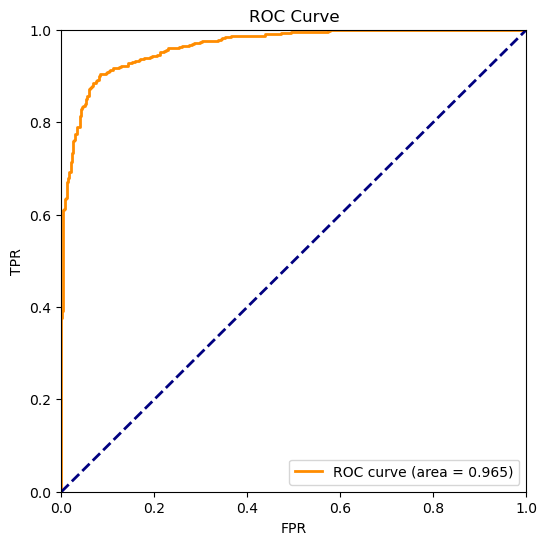

In [155]:
ROC_test(out_loader,model)

In [146]:
#画置信柱状图
def show_bar(ROC_data,model):
    score_list=np.array([])
    label_list=np.array([])
    true_list=[0,0,0,0,0]
    false_list=[0,0,0,0,0]
    model.eval()
    with torch.no_grad():
        for X,y in ROC_data:
            X,y=X.to(device),y.to(device)
            #X=torch.nn.functional.normalize(X)
            pred=model(X)
            #pred=torch.round(model(X))
            label=y.cpu().numpy()
            score=pred.cpu().numpy()
            if score>0 and score<0.2:
                if label==0:
                    true_list[0]=true_list[0]+1
                else:
                    false_list[0]=false_list[0]+1
            elif score>=0.2 and score<0.4:
                if label==0:
                    true_list[1]=true_list[1]+1
                else:
                    false_list[1]=false_list[1]+1
            elif score>=0.4 and score<0.5:
                if label==0:
                    true_list[2]=true_list[2]+1
                else:
                    false_list[2]=false_list[2]+1
            elif score>=0.5 and score<0.6:
                if label==1:
                    true_list[2]=true_list[2]+1
                else:
                    false_list[2]=false_list[2]+1
            elif score>=0.6 and score<0.8:
                if label==1:
                    true_list[3]=true_list[3]+1
                else:
                    false_list[3]=false_list[3]+1
            else :
                if label==1:
                    true_list[4]=true_list[4]+1
                else:
                    false_list[4]=false_list[4]+1
            #if score>0.5 and 1-score<0.3:
            #    score=score
            #elif score>0.5 and 1-score>=0.3:
            #    score=score-0.2
            #if score<0.5 and score-0<0.3:
            #    score=score
            #else:
            #    score=score+0.2
            label_list=np.append(label_list,values=label)
            score_list=np.append(score_list,values=score)
    sum=true_list[0]+true_list[1]+true_list[2]+true_list[3]+true_list[4]
    print(sum)
    regions = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1"]
    true_1 = [true_list[0], true_list[1], true_list[2], true_list[3], true_list[4]]
    false_2 = [false_list[0], false_list[1],false_list[2],false_list[3], false_list[4]]

    fig, ax = plt.subplots(figsize=(10, 7))
    # 先创建一根柱子，显示各个区间true
    ax.bar(regions, true_1, color=[0.8,0.1,0.2], label="True_prediction")
    # 第二根柱子“堆积”在第一根柱子上方，通过'bottom'调整，显示false
    ax.bar(regions, false_2, color=[0.1,0.9,0.2], bottom=true_1, label="False_prediction")

    ax.set_title("Model probability stacked bar plot", fontsize=15)
    ax.set_xlabel("Probability interval")
    ax.set_ylabel("Sample numbers")
    ax.legend()
    plt.grid(False)
    plt.savefig ("confidence.png",dpi=300) 
    plt.show()
    

1280


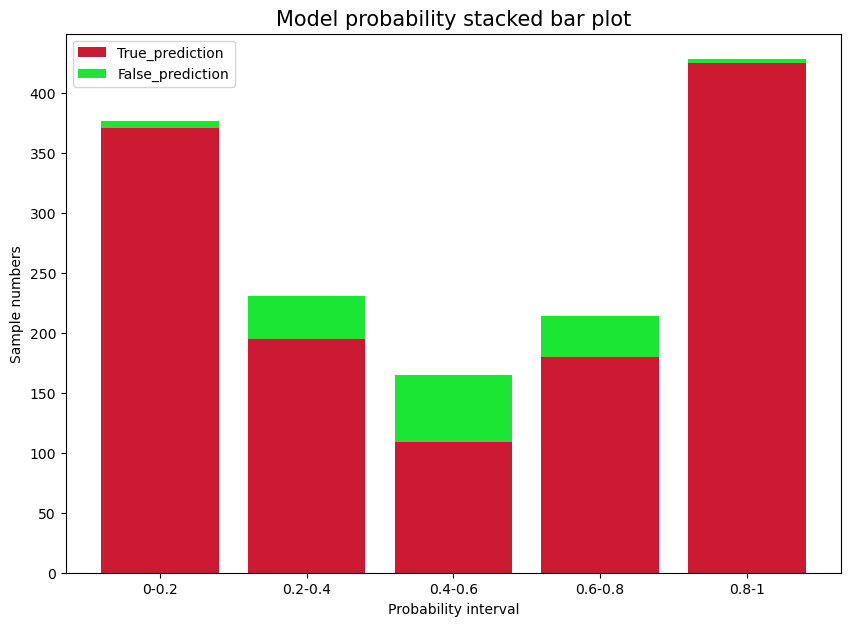

In [147]:
show_bar(out_loader,model)